# Influence of diversity on model performance

In [1]:
# Imports
import os
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as pn
from skbio.diversity.alpha import shannon,pielou_e,simpson,gini_index
from scipy.stats import spearmanr

# Set directory
os.chdir('path_to_your_dir')

### Size vs performance

In [2]:
# Get performance metrics
def get_values(tcrex,epitope,column):
    return tcrex[tcrex['epitope']==epitope][column].tolist()[0]

tcrex = pd.read_csv('./data/parsed/tcrex_models.csv')
tcrex = tcrex.rename(columns = {'average_precision': 'Average precision'})

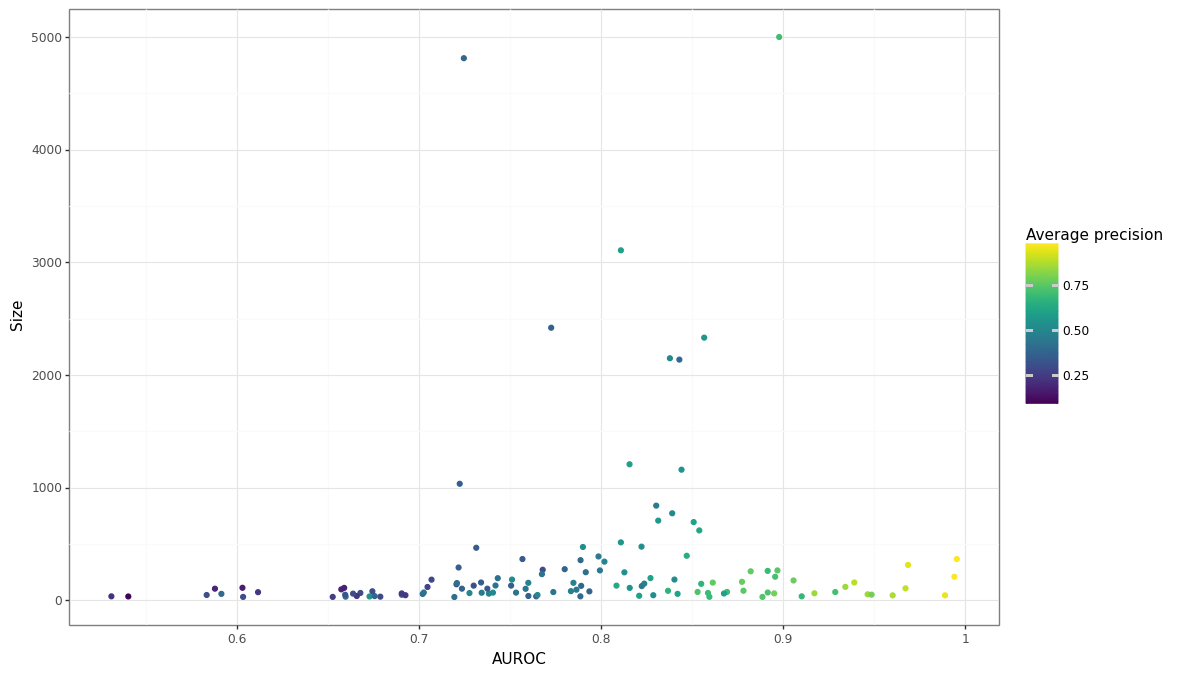

<ggplot: (8763186185997)>

In [3]:
(pn.ggplot(tcrex, pn.aes(x= 'roc_auc',y = 'nr_target_sequences',colour='Average precision')) + 
 pn.geom_point() +
 #pn.geom_text(angle=90,size=5,color='black')+
 pn.theme_bw() +
 pn.labels.ylab('Size') +
 pn.labels.xlab('AUROC') +
 pn.theme(figure_size=(12, 8)))

In [4]:
spearmanr(tcrex['nr_target_sequences'].tolist(),tcrex['roc_auc'].tolist())

SignificanceResult(statistic=0.29784642770943637, pvalue=0.0007060650352825007)

In [5]:
selection = tcrex[tcrex['nr_target_sequences']<=1000]
spearmanr(selection['nr_target_sequences'].tolist(),selection['roc_auc'].tolist())

SignificanceResult(statistic=0.30532317454314134, pvalue=0.0008598501673325207)

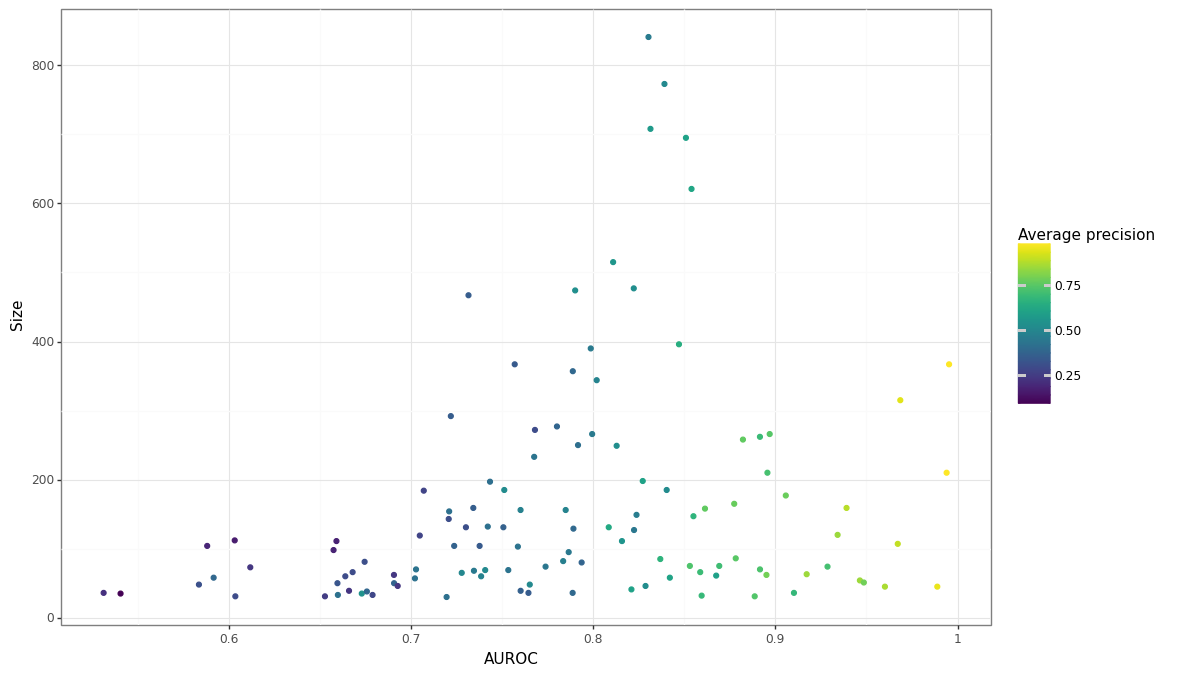

<ggplot: (8763179496295)>

In [6]:
(pn.ggplot(selection, pn.aes(x= 'roc_auc',y = 'nr_target_sequences',colour='Average precision')) + 
 pn.geom_point() +
 #pn.geom_text(angle=90,size=5,color='black')+
 pn.theme_bw() +
 pn.labels.ylab('Size') +
 pn.labels.xlab('AUROC') +
 pn.theme(figure_size=(12, 8)))



### Determine the number of non-clustered TCRs

In [7]:
# Read in clusters and their sizes
clusters = pd.read_csv('./results/epitope_specific_clustering/epitope_specific_clusters.tsv')

# Count nr of clustered TCRs per epitope
clusters = clusters[['epitope','size']]
nr = clusters.groupby('epitope').sum()
nr = nr.rename(columns={'size':'clustered_tcrs'}).reset_index()
nr['training_size'] = nr['epitope'].apply(lambda x: get_values(tcrex,x,'nr_target_sequences'))
nr['singles'] = nr['training_size'] - nr['clustered_tcrs']
nr


,epitope,clustered_tcrs,training_size,singles
0,ALSKGVHFV,14,129,115
1,ALSQYHVYV,21,69,48
2,AMFWSVPTV,17,82,65
3,ARMILMTHF,9,66,57
4,ATDALMTGY,41,177,136
...,...,...,...,...
107,YIFFASFYY,8,272,264
108,YLDAYNMMI,32,197,165
109,YLNTLTLAV,47,390,343
110,YLQPRTFLL,149,315,166


### Calculate diversity metrics

In [8]:
epitopes = set(nr['epitope'].tolist())

In [9]:
# Initialize empty df
final = pd.DataFrame()

for epitope in epitopes:

    # Get cluster info for epitope
    data = clusters[clusters['epitope']==epitope]
    
    # Get number of clusterered TCRs
    selection = nr[nr['epitope'] == epitope]
    clustered_tcrs = selection['clustered_tcrs'].tolist()[0]

    # Get number of TCRs not present in any cluster
    nr_singles = selection['singles'].tolist()[0]

    # Add singles to cluster df
    singles_df = pd.DataFrame.from_dict({'epitope': epitope,
                                          'size': [1]*nr_singles})
    cluster_sizes = pd.concat([data, singles_df])
    
    # Calculate frequencies
    size = get_values(tcrex,epitope,'nr_target_sequences')
    cluster_sizes['frequency'] = cluster_sizes['size']/size
    
    # Calculate DE50
    cluster_sizes = cluster_sizes.sort_values(by='frequency', ascending=False)
    cluster_sizes['cumulative'] = cluster_sizes['frequency'].cumsum()
    cluster_sizes = cluster_sizes.reset_index()
    index = cluster_sizes[cluster_sizes['cumulative']<=0.5].shape[0]
    de50 = index/size

    # Overview of cluster and sizes
    overview= str(Counter(data['size'].tolist()))

    # Calculate diversity metrices
    pielou = pielou_e(cluster_sizes['size'])
    gini= gini_index(cluster_sizes['size'])
    simp = simpson(cluster_sizes['size'])
    shan = shannon(cluster_sizes['size'], base=2)


    # Combine in df
    counts = pd.DataFrame({'all_clusters':[cluster_sizes.shape[0]],'real_clusters': [data.shape[0]], 'clustered_tcrs':[clustered_tcrs],
                           'Pielou':pielou, 'Simpson':simp, 'Gini':gini, 'Shannon':shan,
                           'epitope':epitope, 'overview':overview,'DE50':de50})
    final = pd.concat([final,counts])

### Study relation with performance metrics

In [10]:
final['roc'] = final['epitope'].apply(lambda x: get_values(tcrex,x,'roc_auc'))
final['Average precision'] = final['epitope'].apply(lambda x: get_values(tcrex,x,'Average precision'))
final['accuracy'] = final['epitope'].apply(lambda x: get_values(tcrex,x,'accuracy'))
final['training_size'] = final['epitope'].apply(lambda x: get_values(tcrex,x,'nr_target_sequences'))
final['%clustered'] = (final['clustered_tcrs']/final['training_size'])*100
final['cluster_size'] = final['clustered_tcrs']/final['real_clusters']
final.sort_values(by='training_size')

# Change column name for figure legends 
final = final.rename(columns = {'real_clusters': 'Number of clusters'})

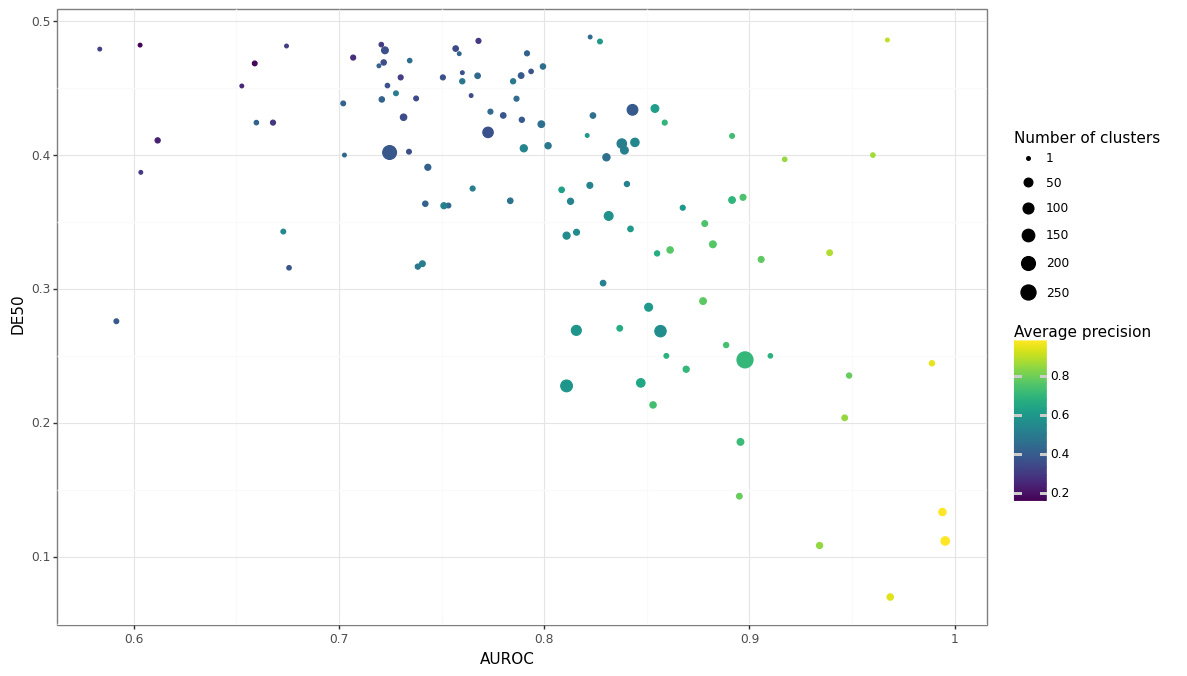

<ggplot: (8763179947021)>

In [11]:
(pn.ggplot(final, pn.aes('roc','DE50',colour='Average precision', size='Number of clusters'))  + 
 pn.geom_point() +
 pn.theme_bw()+
 pn.scales.scale_size_continuous(breaks=[1,50,100,150,200,250,300])+
 pn.labels.ylab('DE50')+
 pn.labels.xlab('AUROC')+
 pn.theme(legend_key = pn.element_blank())+
 
 pn.theme(figure_size=(12, 8)))


In [12]:
spearmanr(final['roc'].tolist(),final['DE50'].tolist())

SignificanceResult(statistic=-0.573441477540848, pvalue=3.8885340901959406e-11)

### Shannon Diversity

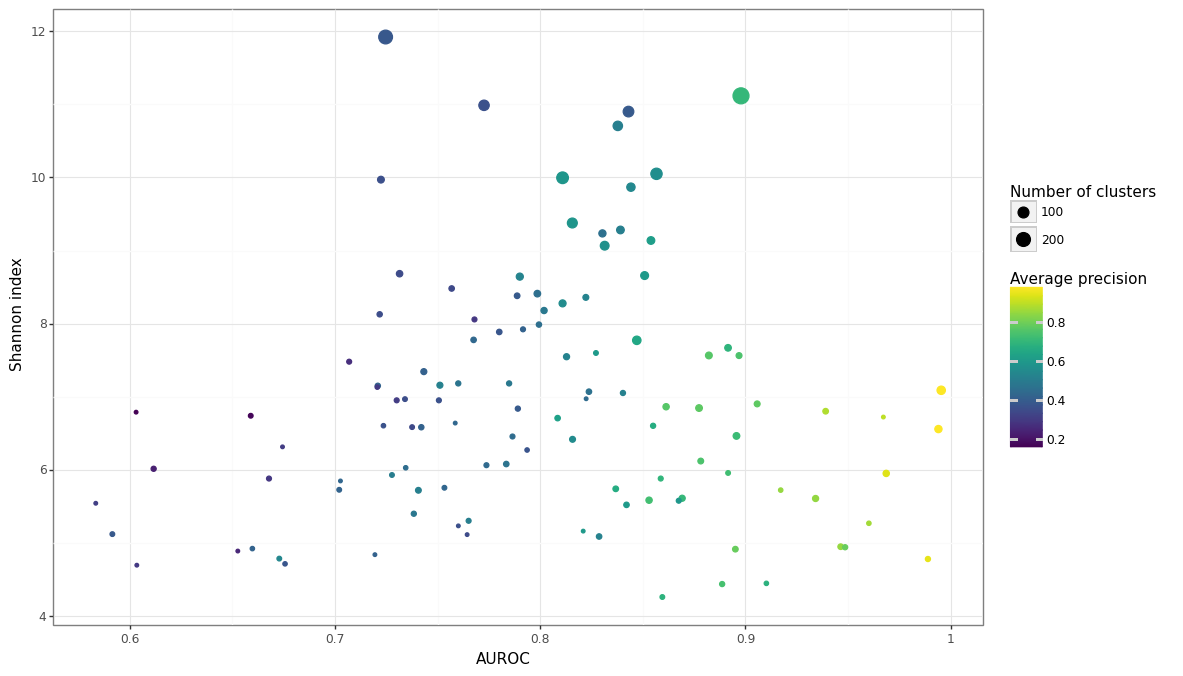

<ggplot: (8763171554428)>

In [13]:
(pn.ggplot(final, pn.aes('roc','Shannon',colour='Average precision',size='Number of clusters'))  + 
 pn.geom_point() +
 pn.theme_bw()+
 pn.labels.ylab('Shannon index')+
 pn.labels.xlab('AUROC')+
 pn.theme(figure_size=(12, 8)))

In [14]:
spearmanr(final['roc'].tolist(),final['Shannon'].tolist())

SignificanceResult(statistic=0.03913562503684013, pvalue=0.6820383787199976)

### Simpson diversity/Gini-simpson index


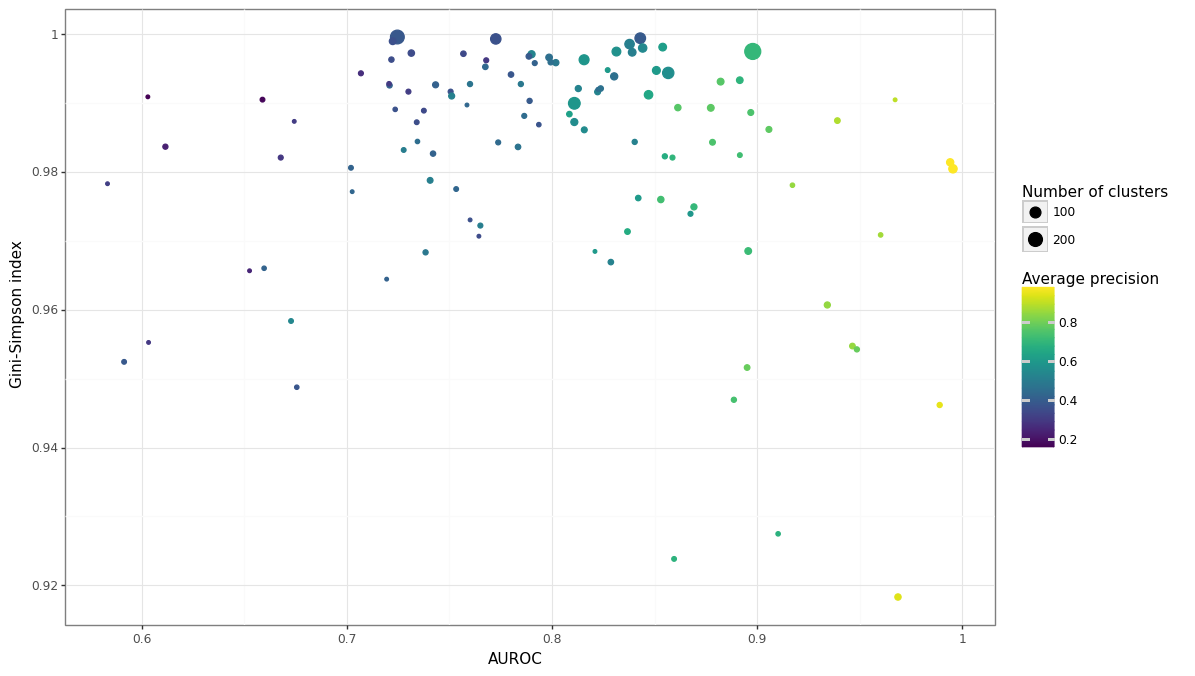

<ggplot: (8763170831156)>

In [15]:
(pn.ggplot(final, pn.aes('roc','Simpson',colour='Average precision',size='Number of clusters'))  + 
 pn.geom_point() +
 pn.labels.xlab(xlab='AUROC')+
 pn.labels.ylab(ylab='Gini-Simpson index')+
 pn.theme_bw()+
 pn.theme(figure_size=(12, 8)))

In [16]:
spearmanr(final['roc'].tolist(),final['Simpson'].tolist())

SignificanceResult(statistic=-0.09811881632340153, pvalue=0.30337219286917977)

### Pielou's index

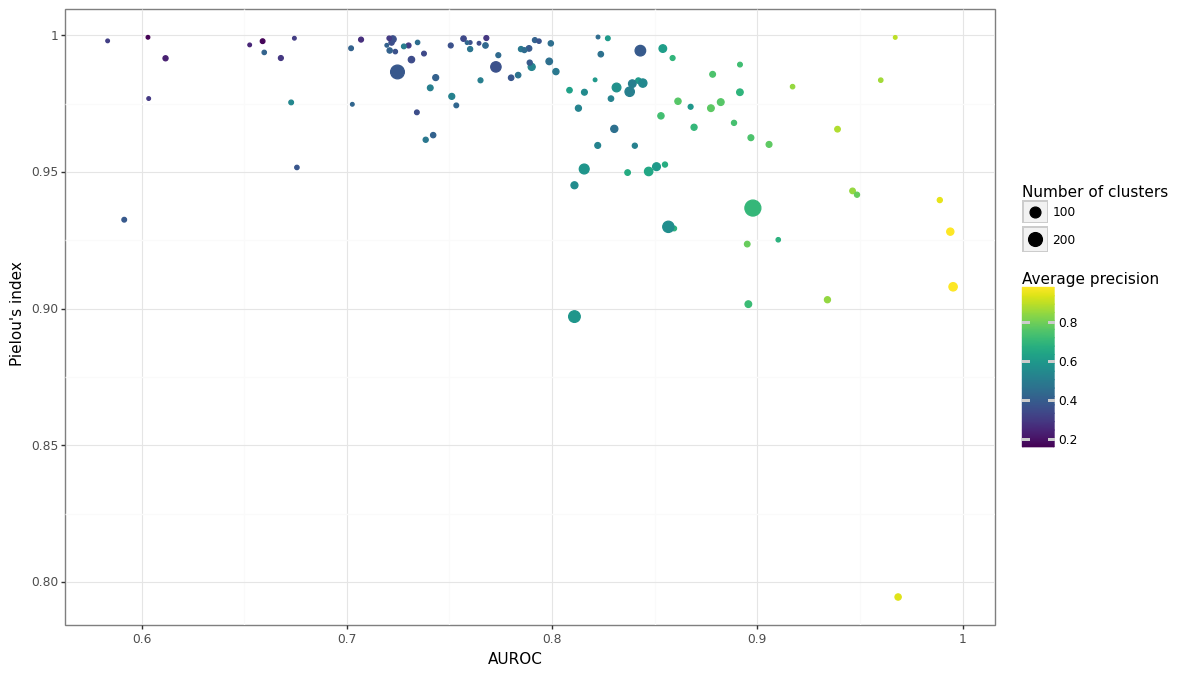

<ggplot: (8763171655069)>

In [17]:
(pn.ggplot(final, pn.aes('roc','Pielou',colour='Average precision',size='Number of clusters'))  + 
 pn.geom_point() +
 pn.labels.xlab(xlab='AUROC')+
 pn.labels.ylab(ylab='Pielou\'s index')+
 pn.theme_bw()+
 pn.theme(figure_size=(12, 8)))

In [18]:
spearmanr(final['roc'].tolist(),final['Pielou'].tolist())

SignificanceResult(statistic=-0.5502777249941554, pvalue=3.278099398299095e-10)

### Gini index

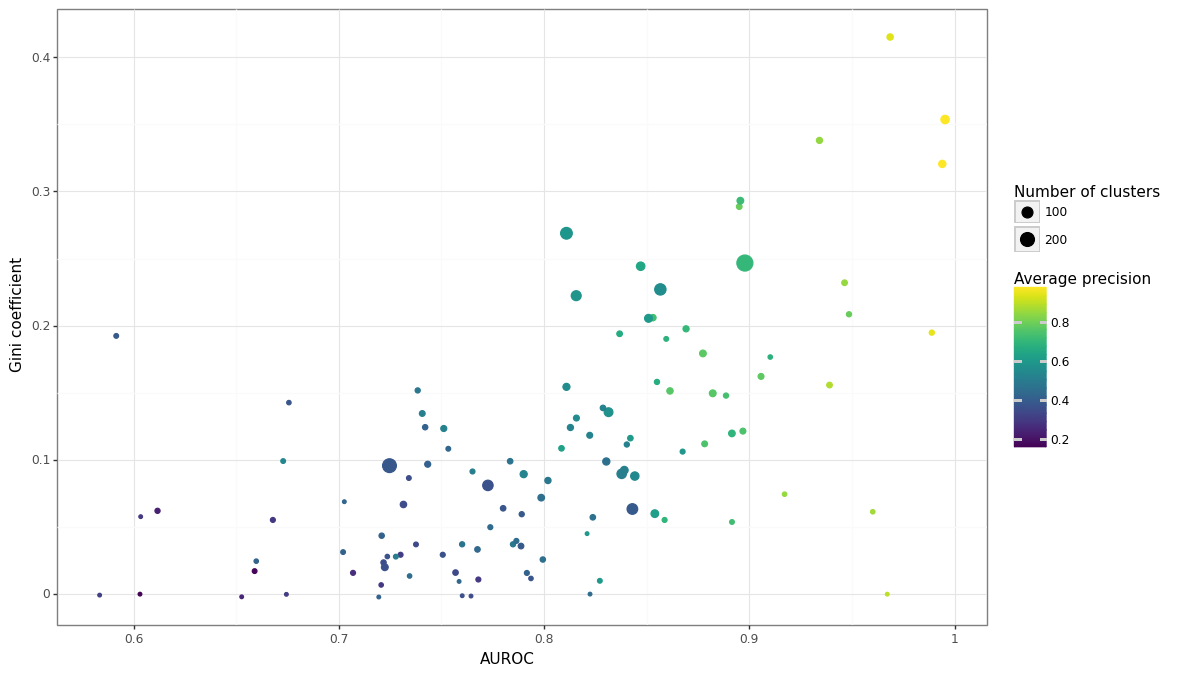

<ggplot: (8763171757734)>

In [19]:
(pn.ggplot(final, pn.aes('roc','Gini',colour='Average precision',size='Number of clusters')) + 
 pn.geom_point() +
 pn.labels.xlab(xlab='AUROC') +
 pn.labels.ylab(ylab='Gini coefficient') +
 pn.theme_bw() +
 pn.theme(figure_size=(12, 8)))

In [20]:
spearmanr(final['roc'].tolist(),final['Gini'].tolist())

SignificanceResult(statistic=0.6082871170328286, pvalue=1.1298079753897328e-12)

In [21]:
final['Number of clusters'].max()

291